In [1]:
import os
from dotenv import load_dotenv
from image_helper import ImageHelper
from datetime import datetime

load_dotenv()

base_url = os.environ.get("STORAGE_URL")
# base_url will be empty if .env file is missing
assert base_url != ""
im_helper = ImageHelper(base_url)

In [2]:
from plantcv import plantcv as pcv
import matplotlib
class options:
    def __init__(self):
        self.debug = "plot"
        self.writeimg= False
        self.result = "results.json"
        self.outdir = "." # Store the output to the current directory

# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug

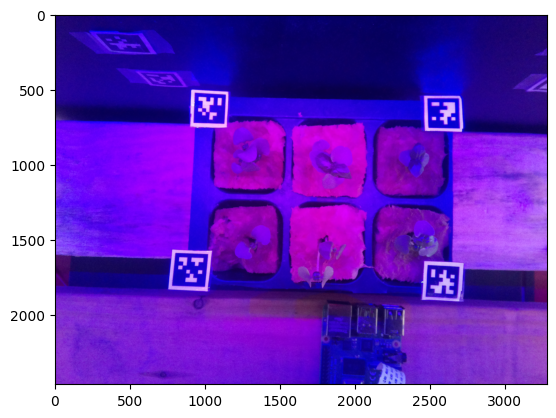

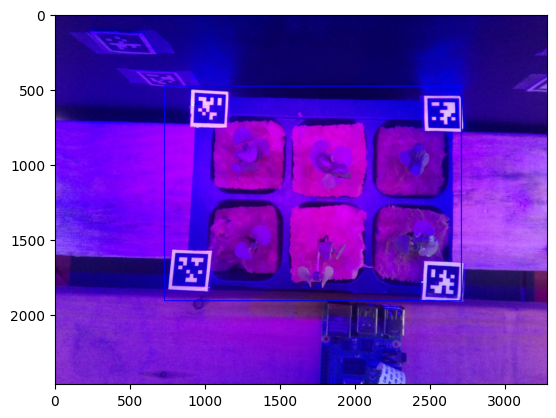

In [3]:
dt_str = '3/12/2022 19:08:18'
dt = im_helper.dt_from_string(dt_str)
assert(im_helper.get(dt, "top"))
img, path, filename = pcv.readimage(im_helper.image.name)
crop_img = pcv.crop(img=img, x=730, y=480, h=1430, w=1980)

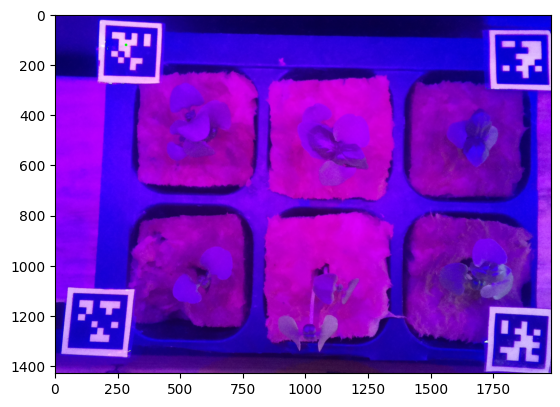

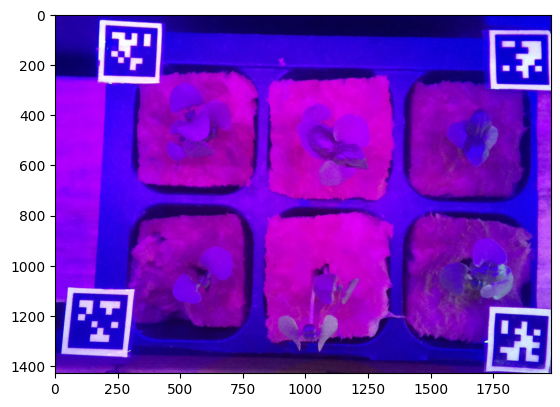

In [5]:
corrected_img = pcv.white_balance(img=crop_img, mode='hist', roi=[280, 120, 5, 5])

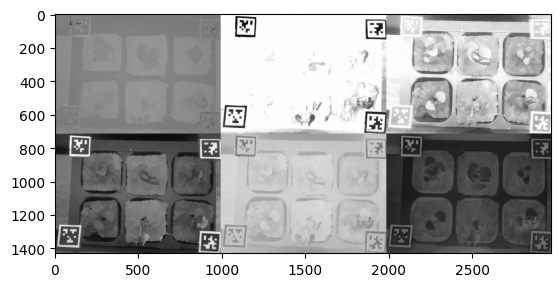

In [28]:
colorspaces = pcv.visualize.colorspaces(rgb_img=corrected_img, original_img=False)


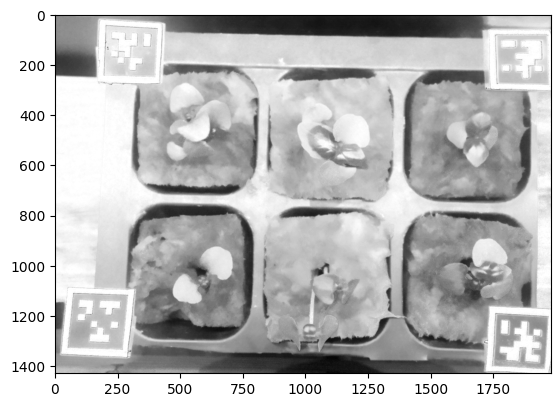

array([[243, 241, 243, ..., 207, 207, 206],
       [235, 235, 234, ..., 207, 207, 206],
       [213, 218, 216, ..., 209, 208, 206],
       ...,
       [208, 210, 215, ..., 227, 225, 228],
       [210, 212, 214, ..., 227, 229, 228],
       [209, 213, 217, ..., 228, 230, 225]], dtype=uint8)

In [12]:
pcv.rgb2gray_hsv(rgb_img=crop_img, channel="v")

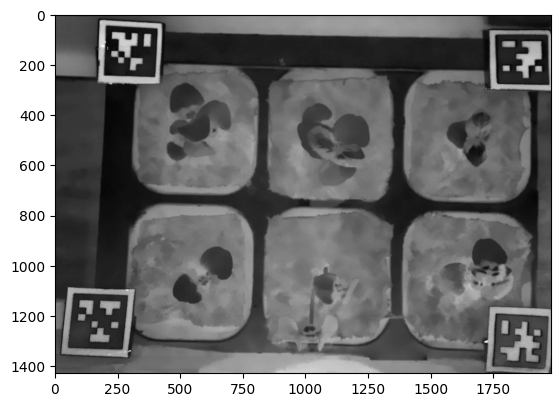

In [8]:
a = pcv.rgb2gray_lab(rgb_img=crop_img, channel='b')


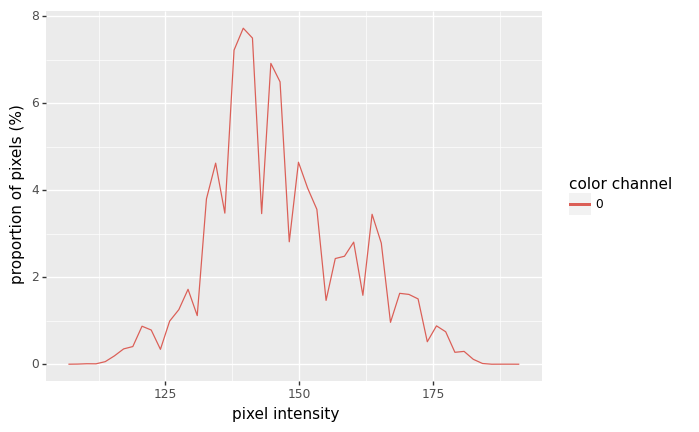

In [9]:
hist = pcv.visualize.histogram(img=a, bins=50)

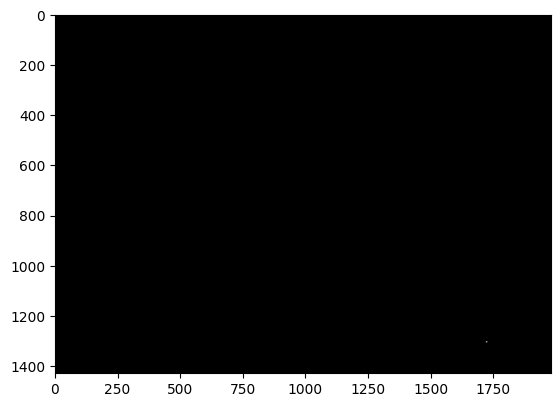

In [31]:
a_thresh = pcv.threshold.binary(gray_img=a, threshold=125, max_value=255, object_type='dark')

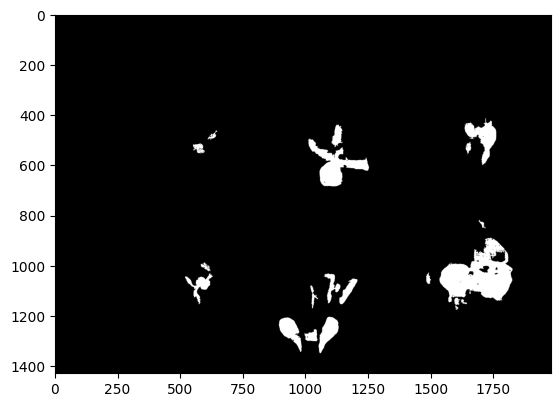

In [13]:
a_fill = pcv.fill(bin_img=a_thresh, size=200)


In [34]:
import cv2

cv2.imwrite("test1.png",corrected_img)

True

In [16]:
import cv2

print("[INFO] loading image...")
image = cv2.imread(im_helper.image.name)
print(image.shape)
image = image[500:1950, 0:3280]
image = cv2.resize(image, (image.shape[0]//2, image.shape[1]//2))
print(image.shape)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2.imwrite("test3.png",image)


[INFO] loading image...
(2464, 3280, 3)
(1640, 725, 3)


True

In [12]:
import apriltag
import cv2

april_tag_real_size = 15.5 #mm
# load the input image and convert it to grayscale
print("[INFO] loading image...")
image = cv2.imread(im_helper.image.name)
image = image[500:1500, 730:1980]
image = cv2.resize(image, (image.shape[0]//2, image.shape[1]//2))
print(image.shape)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# define the AprilTags detector options and then detect the AprilTags in the input image
print("[INFO] detecting AprilTags...")
options = apriltag.DetectorOptions(families="tag36h11")
detector = apriltag.Detector(options)
results = detector.detect(gray)
print("[INFO] {} total AprilTags detected".format(len(results)))

# loop over the AprilTag detection results
tag_coordinates={}
for r in results:
	# extract the bounding box (x, y)-coordinates for the AprilTag
	# and convert each of the (x, y)-coordinate pairs to integers
	(ptA, ptB, ptC, ptD) = r.corners
	ptB = (int(ptB[0]), int(ptB[1]))
	ptC = (int(ptC[0]), int(ptC[1]))
	ptD = (int(ptD[0]), int(ptD[1]))
	ptA = (int(ptA[0]), int(ptA[1]))
	# draw the bounding box of the AprilTag detection
	cv2.line(image, ptA, ptB, (0, 255, 0), 2)
	cv2.line(image, ptB, ptC, (0, 255, 0), 2)
	cv2.line(image, ptC, ptD, (0, 255, 0), 2)
	cv2.line(image, ptD, ptA, (0, 255, 0), 2)
	# draw the center (x, y)-coordinates of the AprilTag
	(cX, cY) = (int(r.center[0]), int(r.center[1]))
	cv2.circle(image, (cX, cY), 5, (0, 0, 255), -1)
	# draw the tag family on the image
	tagFamily = r.tag_family.decode("utf-8")
	cv2.putText(image, tagFamily, (ptA[0], ptA[1] - 15),
		cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
	print("[INFO] tag family: {}".format(tagFamily))
	#find the tag id
	id = r.tag_id
	#log the tag
	tag_coordinates[id] = [cX,cY]
# show the output image after AprilTag detection
display_image = cv2.resize(image, (image.shape[0]//2, image.shape[1]//2))
cv2.imshow("Image", display_image)
print(tag_coordinates)
cv2.waitKey(0)

[INFO] loading image...
(625, 500, 3)
[INFO] detecting AprilTags...
[INFO] 1 total AprilTags detected
[INFO] tag family: tag36h11
{0: [121, 81]}


225